# Подготовка данных

In [38]:
#pip install transformers tokenizers pandas seaborn torch numpy scikit-learn torcheval wandb fasttext

In [2]:
import json
import pandas as pd
import numpy as np
import re
import seaborn as sns
from pathlib import Path
import torch

from sklearn.preprocessing import LabelEncoder
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [3]:
with open("dftrain.jsonl", "r") as f:
    df_train = pd.DataFrame.from_records(map(lambda l: json.loads(l.strip()), f))

with open("dftest.jsonl", "r") as f:
    df_test = pd.DataFrame.from_records(map(lambda l: json.loads(l.strip()), f))

In [4]:
label_encoder = LabelEncoder().fit(df_train["topic_le"])
df_train["topic_le2"] = label_encoder.transform(df_train["topic_le"])
df_test["topic_le2"] = label_encoder.transform(df_test["topic_le"])

In [5]:
num_classes = len(label_encoder.classes_)
num_classes

22

In [6]:
weights_train = torch.from_numpy(df_train['topic_le'].value_counts(normalize=True).values)
weights_test = torch.from_numpy(df_test['topic_le'].value_counts(normalize=True).values)

## Предобработка данных

Сделаем нужную обработку текстов:
 - приведем к нижнему регистру
 - уберем спец. символы и лишние пробелы

In [7]:
def text_prepocessing(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^0-9a-zA-Zа-яА-ЯёЁ]", " ", text)
    text = re.sub(r"\s+", " ", text)    
    return text

In [8]:
df_test['text_preproc'] = df_test.text.apply(text_prepocessing)
df_train['text_preproc'] = df_train.text.apply(text_prepocessing)

## Токенизация

Будем исп-ть BPE (byte pair encoding) токенизацию.

In [9]:
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import BpeTrainer


tokenizer = Tokenizer(BPE())
tokenizer.pre_tokenizer = Whitespace()
trainer = BpeTrainer(special_tokens=["[PAD]", "[MASK]"])

In [10]:
# обучение
tokenizer.train_from_iterator(df_train["text_preproc"], trainer=trainer)

In [11]:
# сохранили в файл
tokenizer.save("tokenizer.json")

In [12]:
# посмотрим на размер словаря
tokenizer.get_vocab_size()
#tokenizer.get_vocab()

30000

In [13]:
# df_test['tokens'] = df_test.text_preproc.apply(lambda x: ' '.join(tokenizer.encode(x).tokens))
# df_train['tokens'] = df_train.text_preproc.apply(lambda x: ' '.join(tokenizer.encode(x).tokens))

In [14]:
# foo = tokenizer.encode(df_test.loc[0, "text_preproc"])
# foo.ids

In [147]:
train_path, test_path = Path("dftrain_dl.jsonl"), Path("dftest_dl.jsonl")
if train_path.exists():
    train_path.unlink()
if test_path.exists():
    test_path.unlink()

with open('dftrain_dl.jsonl', "a", encoding="utf-8") as f:
    for sample in df_train.sample(len(df_train), random_state=123)[['text_preproc', 'topic_le2']].to_dict(orient="records"):
        f.write(json.dumps(sample, ensure_ascii=False) + "\n")

with open('dftest_dl.jsonl', "a", encoding="utf-8") as f:
    for sample in df_test[['text_preproc', 'topic_le2']].to_dict(orient="records"):
        f.write(json.dumps(sample, ensure_ascii=False) + "\n")

Посмотрим на длину последоватеьностей

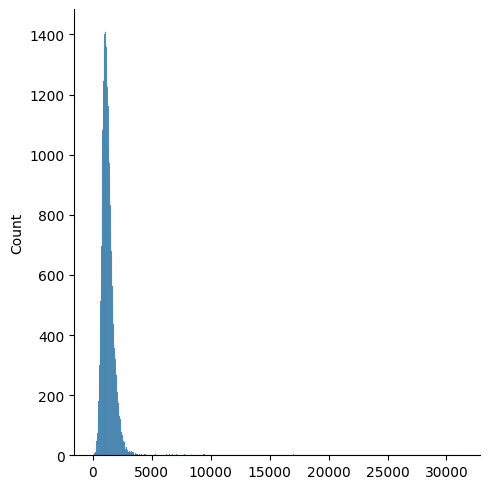

In [15]:
_ = sns.displot([len(sent) for sent in df_test['text_preproc']])

## Датасет

Датасет будет делать следующее:
1. Получает на вход json файл для Tokenizer
2. Будем читать по одной строчке
3. Во время чтения строки вызываем tokernizer.encode(line).ids
4. Будем возвращать словарь с ключами text: line.ids, label: label

In [16]:
from torch.utils.data import Dataset, IterableDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torcheval.metrics.functional import multiclass_f1_score

from collections import defaultdict
from collections.abc import Iterable
from functools import partial
from pathlib import Path
from typing import Any

In [17]:
BATCH_SIZE = 64
MAX_LENGTH = 5000

In [18]:
class MyIterableDataset(IterableDataset):
    def __init__(self, tokenizer_path: Path, dataset_path: Path, max_length: int) -> None:
        self.dataset_path = dataset_path
        self.max_length = max_length
        self.tokenizer = Tokenizer.from_file(str(tokenizer_path))

    def __iter__(self) -> Iterable[dict[str, Any]]:
        with self.dataset_path.open("r", encoding="utf-8") as file:
            counter = 0
            for line in map(lambda x: json.loads(x.strip()), file):
#                 if counter >= 1000:
#                     return
#                 counter += 1
                ids = self.tokenizer.encode(line["text_preproc"]).ids[:self.max_length]
                yield {"text": ids, "topic_le": line["topic_le2"]}

In [18]:
def collate_fn(samples: list[dict[str, Any]]) -> dict[str, torch.Tensor]:
    # len(samples) = batch_size
    # samples: list[dict[str, Any]] -> dict[str, list[Any]]
    # [{"a": 1, "b": 2}, {"a": 3, "b": 4}] -> {"a": [1, 3], "b": [2, 4]}
    # {"text": [[1, 2, 3], [3, 4], [5], [1, 7, 10, 3]], "label": [1, 7, 3, 2]}

    tensor_dict = defaultdict(list)
    for sample in samples:
        for key, value in sample.items():
            tensor_dict[key].append(value)
    
    # Pad values
    out = {
        "text": pad_sequence([torch.tensor(t) for t in tensor_dict["text"]], batch_first=True),
        "topic_le": torch.tensor(tensor_dict["topic_le"]),
    }
    return out

In [153]:
train_set = MyIterableDataset(Path('tokenizer.json'), Path('dftrain_dl.jsonl'), MAX_LENGTH)
test_set = MyIterableDataset(Path('tokenizer.json'), Path('dftest_dl.jsonl'), MAX_LENGTH)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=1, pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=1, pin_memory=True, collate_fn=collate_fn)

In [154]:
# проверим на корректность
next(iter(train_loader))

{'text': tensor([[23429, 10597,  5145,  ...,     0,     0,     0],
         [12235,  8989, 27514,  ...,     0,     0,     0],
         [14437,   199, 17664,  ...,     0,     0,     0],
         ...,
         [ 3835, 27502,  2022,  ...,     0,     0,     0],
         [   75,  6870,   798,  ...,     0,     0,     0],
         [  611, 14042, 13791,  ...,     0,     0,     0]]),
 'topic_le': tensor([11, 20, 16, 11, 16, 18, 11, 13, 16, 18, 16,  5, 16, 20, 11, 16,  9, 16,
         21, 16,  3, 16, 16, 11,  6,  9, 16, 16, 16,  5, 18, 16, 12, 18, 16, 11,
         16, 21, 11, 16, 11, 11,  6,  2, 11,  2, 20, 11, 16, 16, 21, 16, 11, 13,
         21,  6,  2, 17,  5, 21, 16, 13,  2, 11])}

# Модели

## LSTM

In [19]:
import wandb
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [20]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm


sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})


def plot_losses(train_losses, test_losses, train_metrics, valid_metrics):
    clear_output()
    fig, axs = plt.subplots(2, 2, figsize=(13, 4))
    axs[0][0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0][0].plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs[0][0].set_ylabel('loss')

    for (ax1, ax2), train_m_name, valid_m_name in zip(((0, 1), (1, 0), (1, 1)), train_metrics, valid_metrics):
        train_m, valid_m = train_metrics[train_m_name], valid_metrics[valid_m_name]
        axs[ax1][ax2].plot(range(1, len(train_m) + 1), train_m, label='train')
        axs[ax1][ax2].plot(range(1, len(valid_m) + 1), valid_m, label='test')
        axs[ax1][ax2].set_ylabel(train_m_name)

    for ax1 in axs:
        for ax2 in ax1:
            ax2.set_xlabel('epoch')
            ax2.legend()

    plt.show()

In [ ]:
class LSTMClassifier(torch.nn.Module):
    def __init__(
        self,
        tokenizer: Tokenizer,
        num_classes: int,
        embed_dim: int = 256,
        hidden_size: int = 128,
        linear_size: int = 128,
        bidirectional: bool = False,
        dropout_prob: float = 0.1,
        num_layers: int = 1,
    ) -> None:
        super().__init__()
        self._embedding = torch.nn.Embedding(
            num_embeddings=tokenizer.get_vocab_size(),
            embedding_dim=embed_dim,
            padding_idx=tokenizer.get_vocab()["[PAD]"],
        )
        self._lstm = torch.nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=bidirectional,
        )
        self._linear = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(hidden_size * 2 if bidirectional else hidden_size, linear_size),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(linear_size, num_classes),
        )

    def forward(self, tokens: torch.Tensor) -> torch.Tensor:
        batch_size = tokens.size(0)
        embeds = self._embedding(tokens)
        lengths = (tokens != 0).sum(dim=-1).cpu()
        packed = pack_padded_sequence(embeds, lengths=lengths, batch_first=True, enforce_sorted=False)
        lstm_out, (h, c) = self._lstm(packed)
        output, _ = pad_packed_sequence(lstm_out, batch_first=True)
        output = torch.max(output, dim=1).values
        logits = self._linear(output)
        return logits

In [ ]:
LSTMClassifier(tokenizer, num_classes=num_classes)(next(iter(train_loader))["text"]).size()

In [46]:
def accuracy_top_k(logits, labels, k=1):
    batch_size = logits.size(0)
    out = torch.topk(logits, k=k, dim=-1).indices
    top3 = (out.view(batch_size, 1, -1) == labels.view(batch_size, -1, 1)).float().sum() / batch_size
    return top3

def f1_weighted(logits, labels, weights):
    list_f1 = multiclass_f1_score(logits, labels, average=None, num_classes=logits.size(-1))
    return torch.sum(list_f1 * weights)

In [44]:
def training_epoch(model, optimizer, criterion, train_loader, weights, tqdm_desc):
    num_batches = 0
    train_loss = 0
    metrics = defaultdict(float)
    model.train()
    for batch in tqdm(train_loader, desc=tqdm_desc):
        text = batch["text"].to(device)
        labels = batch["topic_le"].to(device)

        optimizer.zero_grad()
        logits = model(text)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        for m_name, m in {
            "accuracy": lambda logits, labels: (logits.argmax(dim=-1) == labels).float().mean(),
            "accuracy top3": partial(accuracy_top_k, k=3),
            "f1 micro": partial(multiclass_f1_score, average="micro", num_classes=logits.size(-1)),
            "f1 macro": partial(multiclass_f1_score, average="macro", num_classes=logits.size(-1)),
            "f1 weighted": partial(f1_weighted, weights=weights)
        }.items():
            metrics[m_name] += m(logits, labels).item()
        num_batches += 1
        if num_batches % 100 == 0:
            wandb.log({
                "batch train loss": train_loss / num_batches,
                **{f"batch train {k}": v / num_batches for k, v in metrics.items()},
            })

    train_loss /= num_batches
    for m_name in metrics:
        metrics[m_name] /= num_batches
    return train_loss, metrics


@torch.no_grad()
def validation_epoch(model, criterion, valid_loader, weights, tqdm_desc):
    num_batches = 0
    valid_loss = 0
    metrics = defaultdict(float)
    model.eval()
    for batch in tqdm(valid_loader, desc=tqdm_desc):
        text = batch["text"].to(device)
        labels = batch["topic_le"].to(device)

        logits = model(text)
        loss = criterion(logits, labels)

        valid_loss += loss.item()
        for m_name, m in {
            "accuracy": lambda logits, labels: (logits.argmax(dim=-1) == labels).float().mean(),
            "accuracy top3": partial(accuracy_top_k, k=3),
            "f1 micro": partial(multiclass_f1_score, average="micro", num_classes=logits.size(-1)),
            "f1 macro": partial(multiclass_f1_score, average="macro", num_classes=logits.size(-1)),
            "f1 weighted": partial(f1_weighted, weights=weights),
        }.items():
            metrics[m_name] += m(logits, labels).item()
        num_batches += 1

    valid_loss /= num_batches
    for m_name in metrics:
        metrics[m_name] /= num_batches
    return valid_loss, metrics


def train(model, optimizer, scheduler, criterion,
          train_loader, valid_loader,
          num_epochs, weights_train, weights_valid, name):
    wandb.init(project="HSE_MLDS_Project_year1", name=name)
    wandb.watch(model)
    
    train_losses, valid_losses = [], []
    train_metrics, valid_metrics = defaultdict(list), defaultdict(list)

    for epoch in range(1, num_epochs + 1):
        train_loss, train_metric = training_epoch(
            model, optimizer, criterion, train_loader, weights_train,
            tqdm_desc=f'Training {epoch}/{num_epochs}'
        )
        valid_loss, valid_metric = validation_epoch(
            model, criterion, valid_loader, weights_valid,
            tqdm_desc=f'Validating {epoch}/{num_epochs}'
        )
        
        # логирование
        wandb.log({
            "train loss": train_loss, "test loss": valid_loss,
            **{f"train {k}": v for k, v in train_metric.items()},
            **{f"test {k}": v for k, v in valid_metric.items()},
            "epoch": epoch, 
            "lr": scheduler.get_last_lr()[0] if scheduler is not None else optimizer.param_groups[-1]['lr']
        })

        if scheduler is not None:
            scheduler.step()

        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        for m_name, m_value in train_metric.items():
            train_metrics[m_name].append(m_value)
        for m_name, m_value in valid_metric.items():
            valid_metrics[m_name].append(m_value)
        plot_losses(train_losses, valid_losses, train_metrics, valid_metrics)
        
    wandb.finish() 
    return train_losses, valid_losses, train_metrics, valid_metrics

In [161]:
NUM_EPOCHS = 100

model = LSTMClassifier(
    tokenizer, num_classes,
    embed_dim=256, hidden_size=128, linear_size=128,
    bidirectional=True, dropout_prob=0.4,
).to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)
criterion = torch.nn.CrossEntropyLoss()

In [162]:
# число параметров
sum(param.numel() for param in model.parameters())

8110998

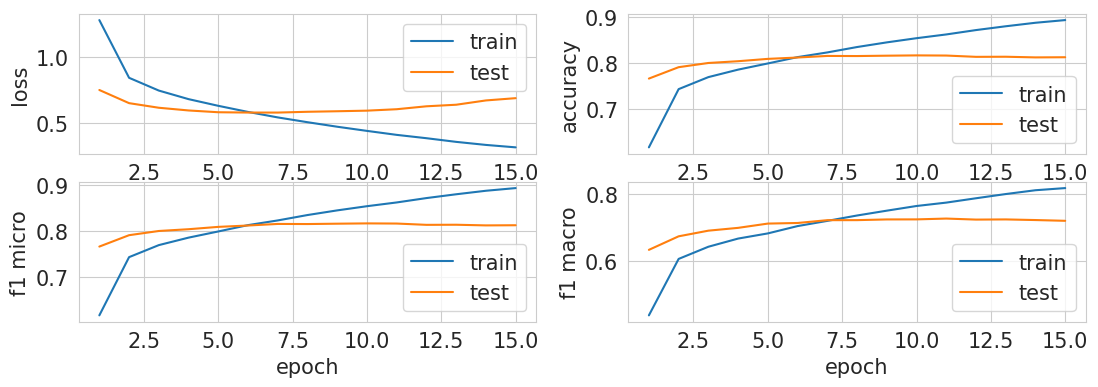

Training 16/100: 0it [00:00, ?it/s]

In [ ]:
train_losses, valid_losses, train_metrics, valid_metrics = train(
    model, optimizer, None, criterion, train_loader, test_loader,
    NUM_EPOCHS, weights_train.to(device), weights_test.to(device),
    name='LSTM--bidirectional-lstm1-v04'
)

## LSTM + FastText

In [26]:
import fasttext.util

In [27]:
fasttext.util.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

In [28]:
class MyDatasetFastText(Dataset):
    def __init__(self, dataset_path: Path, max_length: int) -> None:
        self.max_length = max_length
        with open(dataset_path, "r") as f:
            self.df = pd.DataFrame.from_records(map(lambda l: json.loads(l.strip()), f))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, item):
        line = self.df.iloc[item]
        return {
            "text": np.vstack(
                [ft.get_word_vector(word).astype(np.float32) for word in line["text_preproc"].split()[:self.max_length]]
            ),
            "topic_le": line["topic_le2"],
        }

In [29]:
train_set = MyDatasetFastText(Path('dftrain_dl.jsonl'), MAX_LENGTH)
test_set = MyDatasetFastText(Path('dftest_dl.jsonl'), MAX_LENGTH)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=4, shuffle=True,
                          pin_memory=True, collate_fn=collate_fn)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True, collate_fn=collate_fn)

In [30]:
class LSTMClassifierFastText(torch.nn.Module):
    def __init__(
        self,
        embed_dim,
        num_classes: int,
        hidden_size: int = 128,
        linear_size: int = 128,
        bidirectional: bool = False,
        dropout_prob: float = 0.1,
        num_layers: int = 1,
    ) -> None:
        super().__init__()
        self._lstm = torch.nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_size,
            batch_first=True,
            bidirectional=bidirectional,
        )
        self._linear = torch.nn.Sequential(
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(hidden_size * 2 if bidirectional else hidden_size, linear_size),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=dropout_prob),
            torch.nn.Linear(linear_size, num_classes),
        )

    def forward(self, embeds: torch.Tensor) -> torch.Tensor:
        batch_size = embeds.size(0)
        lengths = (embeds.sum(-1) != 0).sum(dim=-1).cpu()
        packed = pack_padded_sequence(embeds, lengths=lengths, batch_first=True, enforce_sorted=False)
        lstm_out, (h, c) = self._lstm(packed)
        output, _ = pad_packed_sequence(lstm_out, batch_first=True)
        output = torch.max(output, dim=1).values
        logits = self._linear(output)
        return logits

In [34]:
LSTMClassifierFastText(embed_dim=ft.get_dimension(), num_classes=num_classes)(next(iter(train_loader))["text"]).size()

torch.Size([64, 22])

In [39]:
NUM_EPOCHS = 100

model = LSTMClassifierFastText(
    ft.get_dimension(), num_classes,
    bidirectional=True, dropout_prob=0.1,
).to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, NUM_EPOCHS)
criterion = torch.nn.CrossEntropyLoss()

In [40]:
# число параметров
sum(param.numel() for param in model.parameters())

476054

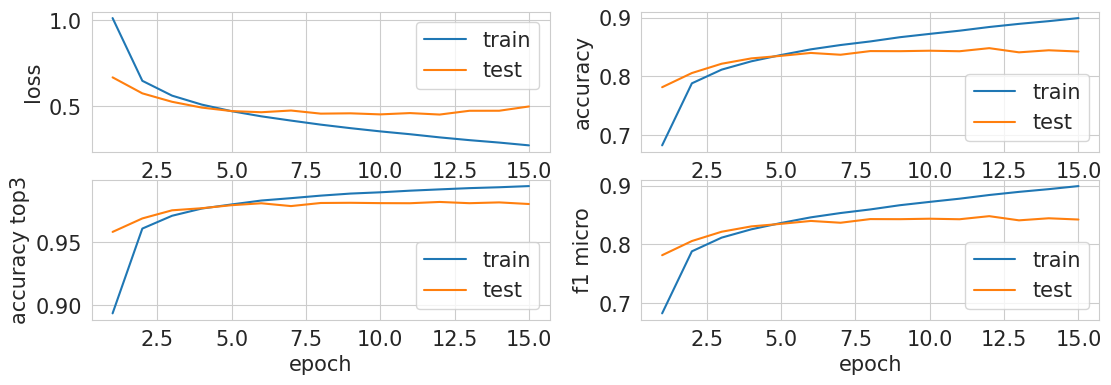

Training 16/100:   0%|          | 0/3243 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
train_losses, valid_losses, train_metrics, valid_metrics = train(
    model, optimizer, None, criterion, train_loader, test_loader,
    NUM_EPOCHS, weights_train.to(device), weights_test.to(device), name='LSTM--fasttext-v02'
)